# SMOOTHING METHODS (HOT-WINTERS)


In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

##  Data Set
Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A. Period of Record: March 1958 - December 2001


In [2]:
data=sm.datasets.co2.load_pandas()
y=data.data
y
#As can be seen, the dates are given weekly.


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [3]:
#Analysing data set monthly is more logical
y=y["co2"].resample("MS").mean()
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [4]:
#Let look missing values
y.isnull().sum()
#Replace null values with average of right before and after values
y=y.fillna((y.bfill()+y.ffill())/2)

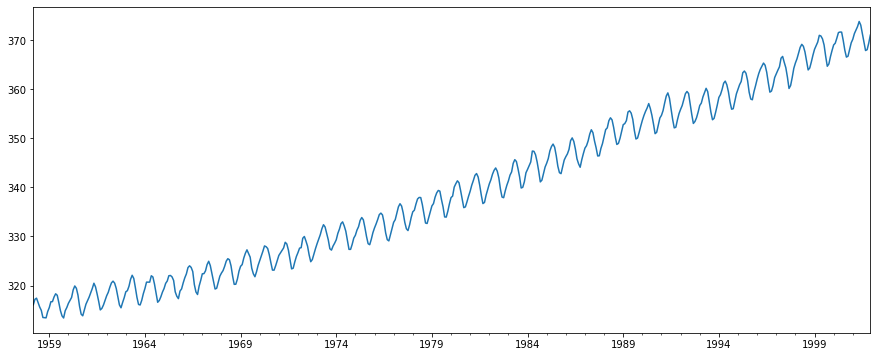

In [5]:
y.plot(figsize=(15,6))
plt.show()

In [6]:
#Let divide the data sets into train and test
train=y[:"1997-12-01"]
print(len(train))
test=y["1998-01-01":]
print(len(test))

478
48


## Zaman Serisinin Yapısal Analizi

### Durağanlık Testi


In [7]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [8]:
is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


### Zaman Serisi Bileşenleri ve Durağanlık Testi

In [9]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

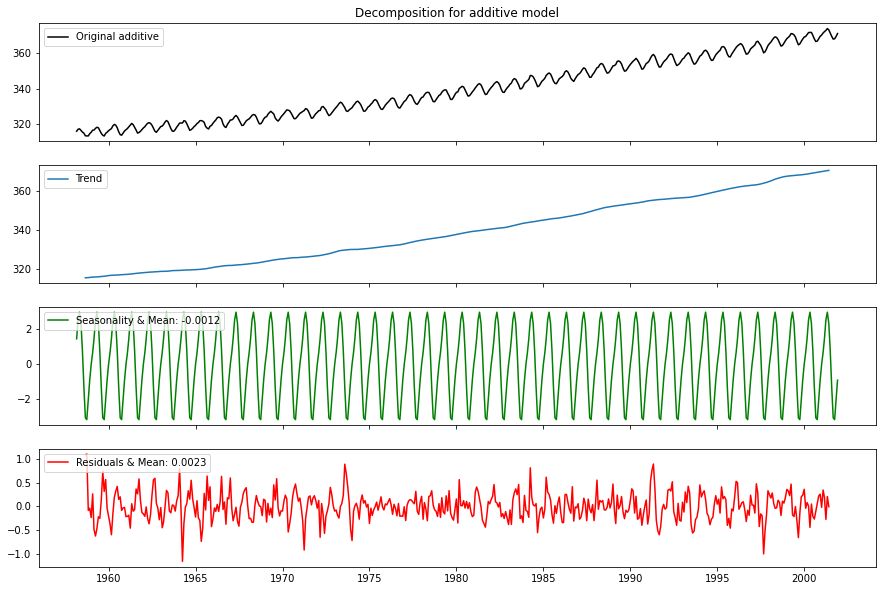

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [10]:
ts_decompose(y,stationary=True)

## Single Exponential Smoothing (SES)

In [11]:
ses_model=SimpleExpSmoothing(train).fit(smoothing_level=0.5)
y_pred=ses_model.forecast(48)
mean_absolute_error(test,y_pred)

5.706393369643809

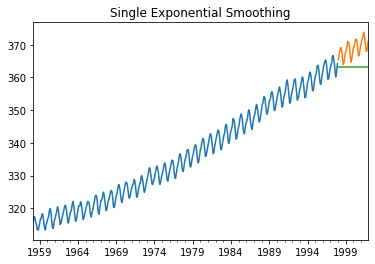

In [12]:
train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()
#Our predictions are very unsuccesful because SES method is not usefull if our data has trends or seasonality

In [13]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

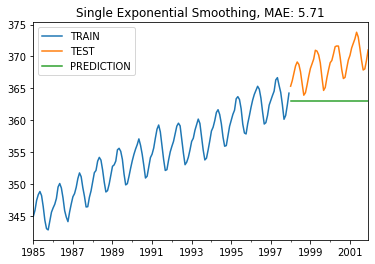

In [14]:
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [15]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.49858571649247,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### SES Hyperparameter Optimization

In [16]:
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [17]:
alphas=np.arange(0.8,1,0.01)
# yt_sapka = a * yt-1 + (1-a)* (yt_-1)_sapka
best_alpha,best_mae=ses_optimizer(train,alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


#### Final SES Model

In [18]:
ses_final_model=SimpleExpSmoothing(train).fit(best_alpha)
y_pred=ses_final_model.forecast(48)
mean_absolute_error(test,y_pred)

4.545056761011275

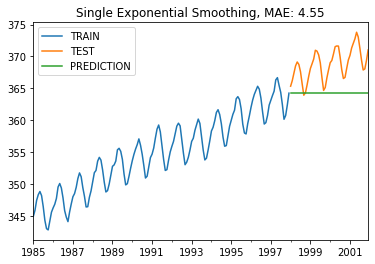

In [19]:
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

## Double Exponential Smoothing (DES)

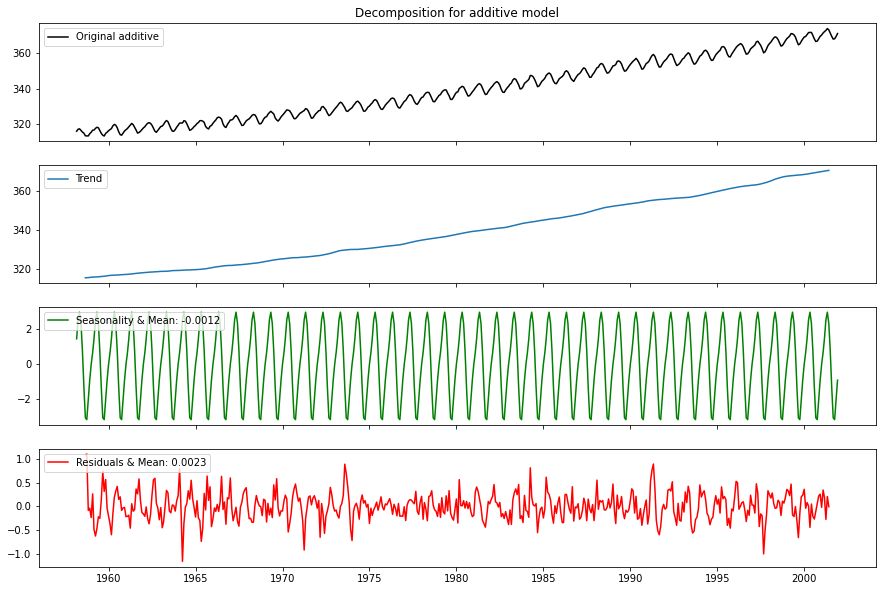

In [20]:
# DES: Level (SES) + Trend

# y(t) = Level + Trend + Seasonality + Noise
# y(t) = Level * Trend * Seasonality * Noise

ts_decompose(y)

In [21]:
#Model setup
des_model=ExponentialSmoothing(train,trend="add").fit(smoothing_level=0.5,
                                                     smoothing_trend=0.5)

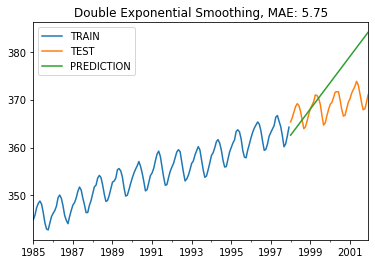

In [22]:
y_pred=des_model.forecast(48)
plot_co2(train,test,y_pred,"Double Exponential Smoothing")

### Hyperparameter Optimization

In [23]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [24]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 2.382
alpha: 0.01 beta: 0.11 mae: 2.8401
alpha: 0.01 beta: 0.21 mae: 2.7568
alpha: 0.01 beta: 0.31 mae: 2.1708
alpha: 0.01 beta: 0.41 mae: 2.8727
alpha: 0.01 beta: 0.51 mae: 2.5141
alpha: 0.01 beta: 0.61 mae: 1.81
alpha: 0.01 beta: 0.71 mae: 1.7386
alpha: 0.01 beta: 0.81 mae: 2.2035
alpha: 0.01 beta: 0.91 mae: 4.8932
alpha: 0.11 beta: 0.01 mae: 2.4335
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.822
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 bet

### Final Model

In [25]:
final_des_model=ExponentialSmoothing(train,trend="add").fit(smoothing_level=best_alpha,
                                               smoothing_trend=best_beta)

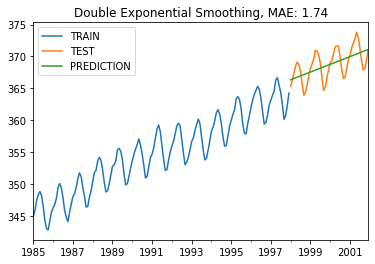

In [26]:
y_pred=final_des_model.forecast(48)
plot_co2(train,test,y_pred,"Double Exponential Smoothing")

## Triple Exponential Smoothing (Holt-Winters)

In [27]:
# TES = SES + DES + Mevsimsellik

#Model setup
tes_model=ExponentialSmoothing(train,trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                     smoothing_trend=0.5,
                                                     smoothing_seasonal=0.5)

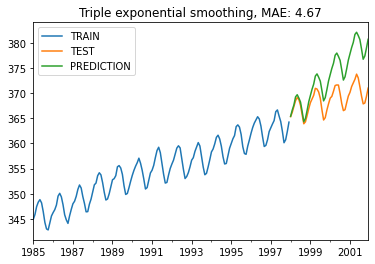

In [28]:
y_pred=tes_model.forecast(48)
plot_co2(train,test,y_pred,"Triple exponential smoothing")

### Hyperparameter Optimization

In [29]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

abg = list(itertools.product(alphas, betas, gammas))


def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.78]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.44]
[0.2, 0.4, 0.8, 11.05]
[0.2, 0.4, 0.9, 4.49]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.81]
[0.2, 0.5, 0.7, 3.15]
[0.2, 0.5, 0.8, 4.67]
[0.2, 0.5, 0.9, 3.36]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 0.62]
[0.2, 0.6, 0.6, 1.78]
[0.2, 0.6, 0.7, 2.66]
[0.2, 0.6, 0.8, 235.02]
[0.2, 0.6, 0.9, 470533357867.13]
[0.2, 0.7, 0.2, 4.71]
[0.2, 0.7, 0.3, 4.57]
[0.2, 0.7, 0.4, 7.48]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 2.0

[0.7, 0.5, 0.8, 6.57]
[0.7, 0.5, 0.9, 6.49]
[0.7, 0.6, 0.2, 6.52]
[0.7, 0.6, 0.3, 5.24]
[0.7, 0.6, 0.4, 2.8]
[0.7, 0.6, 0.5, 1.08]
[0.7, 0.6, 0.6, 2.42]
[0.7, 0.6, 0.7, 3.74]
[0.7, 0.6, 0.8, 10.61]
[0.7, 0.6, 0.9, 2.79]
[0.7, 0.7, 0.2, 8.05]
[0.7, 0.7, 0.3, 6.12]
[0.7, 0.7, 0.4, 4.33]
[0.7, 0.7, 0.5, 1.71]
[0.7, 0.7, 0.6, 1.61]
[0.7, 0.7, 0.7, 1.72]
[0.7, 0.7, 0.8, 84.95]
[0.7, 0.7, 0.9, 173888717842.48]
[0.7, 0.8, 0.2, 9.44]
[0.7, 0.8, 0.3, 7.2]
[0.7, 0.8, 0.4, 6.17]
[0.7, 0.8, 0.5, 2.54]
[0.7, 0.8, 0.6, 0.68]
[0.7, 0.8, 0.7, 4332.51]
[0.7, 0.8, 0.8, 16916586911192.68]
[0.7, 0.8, 0.9, 5.4389117593304595e+17]
[0.7, 0.9, 0.2, 10.61]
[0.7, 0.9, 0.3, 8.62]
[0.7, 0.9, 0.4, 8.46]
[0.7, 0.9, 0.5, 1.82]
[0.7, 0.9, 0.6, 260537.61]
[0.7, 0.9, 0.7, 3691940148334.92]
[0.7, 0.9, 0.8, 77590252520649.31]
[0.7, 0.9, 0.9, 1.4250832941559017e+18]
[0.8, 0.2, 0.2, 1.95]
[0.8, 0.2, 0.3, 1.96]
[0.8, 0.2, 0.4, 1.48]
[0.8, 0.2, 0.5, 0.79]
[0.8, 0.2, 0.6, 0.69]
[0.8, 0.2, 0.7, 1.61]
[0.8, 0.2, 0.8, 2.06]
[0.8

### Final TES Model

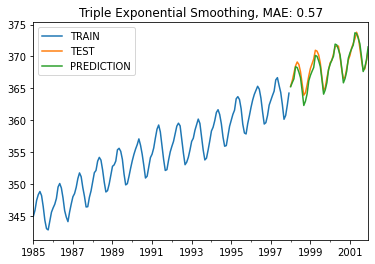

In [34]:
final_tes_model=ExponentialSmoothing(train,trend="add",seasonal="add",seasonal_periods=12).\
                                    fit(smoothing_level=best_alpha,smoothing_trend=best_beta,smoothing_seasonal=best_gamma)
y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")